<a href="https://colab.research.google.com/github/Babcock-R17/Image-Processing/blob/main/Independent_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASKS

1. ToDo's 
  * Watermark detection based on nonlinear optimization 
  * Exploration of Blur kernal and watermark recovery for steganography and cryptography keys. 
  * Increase accuracy on watermark removal and noise and blur 
  * Add titles to images and create a streamlined reporting tool for EDA  
2. Bugs... 
  * if watermark is larger than image a value error may occur
    * to fix this I should just catch the error and set a new watermark image such that it is contained in the target image. 
    * use try: except




# pip installs

In [26]:
# Install pillow in order to import PIL 
!pip install pillow
!pip install overloading
!pip install scikit-image

In [27]:
!pip install opencv-python

# Class Reference



Photo Class as Super

```python
class Photo():
  def __init__(self, fp, fname, image):
    self.__fp = fp
    self.__fname = fname
    self.__image = image.astype(np.float32)
    self.__shape = np.asarray(image).shape
    self.__title = fname
```
Image_Processing class as Child. 
```python
class Image_Processing(Photo):
  def __init__(self, fp , fname, img):
    super().__init__(fp, fname, img)
    self.__blur = None
    self.__noise = None
    self.__kernel_size = (0, 0)
    self.__sigma_blur = None
    self.__sigma_noise = None
    self.__mean_noise = None
```

# Run Code for Classes

In [28]:
# Coded by: Jasen Babcock Python 3.7 in Google Colab 03_04_2022
# Imports
from os import listdir
import os
from skimage import io, transform
import PIL
import matplotlib.pyplot as plt
import numpy as np
from typing import overload
import skimage as sk
from multiprocessing import SimpleQueue
from cv2 import cv2


# Class objects
# Parent Class
class Photo():
  def __init__(self, fp, fname, image):
    self.__fp = fp
    self.__fname = fname
    self.__image = image.astype(np.float32)
    self.__shape = np.asarray(image).shape
    self.__title = fname
    

  @property
  def fp(self):
    return self.__fp
  @property
  def fname(self):
    return self.__fname 
  @property
  def image(self):
    return self.__image
  @property
  def shape(self):
    return self.__shape
  @property
  def width(self):
    return self.__shape[0]
  @property
  def height(self):
    return self.__shape[1]
  @property
  def channel(self):
    try:
      return self.__shape[2]
    except ValueError as e:
      print(e)
      return None
  @property
  def title(self):
    return self.__title

  @fp.setter
  def fp(self, fp):
    self.__fp = fp  
  @fname.setter
  def fname(self, fname):
    self.__fname = fname 
  @image.setter
  def image(self, image):
    self.__image = image
  @shape.setter
  def shape(self, shape):
    self.__shape = shape
  @title.setter
  def title(self, title):
    self.__title = title
  


  # Class Methods
  def describe(self):
    name = self.fname
    shape = self.shape 
    print("Image {} has a shape of {} ".format(name, shape))

  def add_to_book(self, book):
    book[self.__fname] = self

  def is_in_book(self, book):
    return self.__image in book.value
      
  def show(self):
    io.imshow((self.__image).astype(np.uint8))
    io.show()
  
  @staticmethod
  def load(fp, fname):
    img = io.imread(os.path.join(fp, fname))
    return img
  @staticmethod
  def save(fp, fname, image_array):
    io.imsave(os.path.join(fp, fname), image_array)
  @staticmethod
  def show_array(image_array):
    io.imshow(image_array.astype(np.uint8))
    io.show()
  @staticmethod
  def show_multiple(book):
    """
    Shows all Images within the dictionary object.
    """
    keys = list(book.keys())
    plt.subplot(2*(len(keys)//2), 2*(len(keys)//2), len(keys))
    i = 0
    for key in keys:
      plt.subplot(2*(len(keys)//2), len(keys)-(len(keys)//2), 1+i)
      io.imshow((book[key].image).astype(np.uint8))
      i+=1
    io.show()



# Child class
class Image_Processing(Photo):
  def __init__(self, fp , fname, img):
    super().__init__(fp, fname, img)
    self.__blur = None
    self.__noise = None
    self.__kernel_size = (0, 0)
    self.__sigma_blur = None
    self.__sigma_noise = None
    self.__mean_noise = None

  @property
  def blur(self):
    return self.__blur
  @property
  def noise(self):
    return self.__noise
  @property
  def kernel_size(self):
    return self.__kernel_size
  @property
  def sigma_blur(self):
    return self.__sigma_blur
  @property
  def mean_noise(self):
    return self.__mean_noise
  @property
  def sigma_noise(self):
    return self.__sigma_noise

  @kernel_size.setter
  def kernel_size(self, ksize):
    self.__kernel_size = ksize
  @sigma_blur.setter
  def sigma_blur(self, sigma_blur):
    self.__sigma_blur = sigma_blur
  @mean_noise.setter
  def mean_noise(self, mean_blur):
    self.__mean_blur = mean_blur
  @sigma_noise.setter
  def sigma_noise(self):
    self.__sigma_noise = sigma_noise


  # Class Methods
  def blur_img(self, ksize, sigma_blur):
    self.kernel_size = ksize
    self.sigma_blur = sigma_blur
    blur = cv2.GaussianBlur(self.image, self.kernel_size, sigmaX=self.sigma_blur,
                       sigmaY=self.sigma_blur, borderType=cv2.BORDER_CONSTANT)
    self.__blur = Photo(fp=self.fp, fname="blured_"+self.fname, image=blur)

  def noise_img(self, mean_noise, sigma_noise):
    self.__mean_noise = mean_noise
    self.__sigma_noise = sigma_noise
    __n = np.random.normal(self.mean_noise, self.sigma_noise, self.shape)
    self.__noise = Photo(fp=self.fp, fname="noised_"+self.fname, image=__n)
  
  def alpha_blend_watermark(self, watermark_array, scale , location, alpha):
    def alpha_composite(img1, img2, alpha1):
      return img1*alpha1 + (1-alpha1)*img2
    
    sp = lambda xf: [ xf[:,:,ch] for ch in range(xf.shape[2]) ]

    h,w,c = watermark_array.shape
    h_hat, w_hat = int(scale*h) , int(scale*w)
    water_test = transform.resize(watermark_array, (h_hat, w_hat, 4), cval=0)
    water_test = (water_test.astype(np.float32))

    blue, green, red = sp(self.image/255)
    blue1, green1, red1, a = sp(water_test/255)
    a = np.asarray( a, dtype='float32' )

    x1, y1 = a.shape
    startx,starty = location
    x1,y1 = x1+startx, y1+starty

    rgb = self.image/255
    rgb[startx:x1,starty:y1,2] = red1 *a + (1.0 - a) * red[startx:x1,starty:y1]
    rgb[startx:x1,starty:y1,1] = green1 *a + (1.0 - a) * green[startx:x1,starty:y1]
    rgb[startx:x1,starty:y1,0] = blue1*a + (1.0 - a) * blue[startx:x1,starty:y1]

    rgb = (255*rgb).astype(np.uint8)

    return alpha_composite(self.image, rgb, alpha) 


# Driver for my Image processing tasks

In [29]:
# Mount Google Colab to load in images. 
from google.colab import drive
drive.mount('/gdrive')

# Get file paths
workspace_path = '/gdrive/MyDrive/Independent_Study/'
workspace_names = listdir(workspace_path)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Defining my folder paths and image names

In [30]:
# Set file paths
## Image file Path
img_path = os.path.join(workspace_path, "Full_Images/Custom")
image_names = listdir(img_path)

print("Images from {} loaded into book \nImages loaded are {}".format(img_path, image_names))

Images from /gdrive/MyDrive/Independent_Study/Full_Images/Custom loaded into book 
Images loaded are ['knitted_0175.jpg', 'striped_0088.jpg', 'banded_0009.jpg', 'fibrous_0035.jpg', 'chequered_0121.jpg']


In [31]:
## Watermark file path
water_path = os.path.join(workspace_path, "Watermarks/")
watermark_names = listdir(water_path)

print("Watermark images from {} loaded into water_book \nImages loaded are {}".format(water_path, watermark_names))

Watermark images from /gdrive/MyDrive/Independent_Study/Watermarks/ loaded into water_book 
Images loaded are ['water_mark_text.png', 'water_mark_blue_brush.png', 'water_mark_bbb_watercolor_spray.png', 'ewuSIAM_logo.png']


## Forms to explore Images

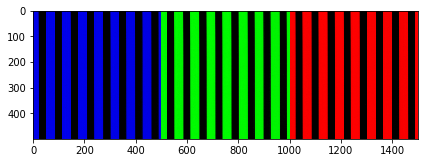

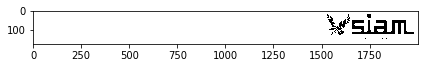

In [32]:
#@title Select an Image {display-mode: "form", run: "auto"}
#@markdown ---
select_image = 'banded_0009.jpg' #@param ['knitted_0175.jpg', 'striped_0088.jpg', 'banded_0009.jpg', 'fibrous_0035.jpg', 'chequered_0121.jpg']
select_watermark = 'ewuSIAM_logo.png' #@param ['water_mark_bbb_watercolor_spray.png', 'water_mark_text.png', 'ewuSIAM_logo.png', 'water_mark_blue_brush.png']
#@markdown ---

# loads a photo from the file path and file name
## creating an Image_Processing Object
img = Photo.load(fp=img_path, fname=select_image)
img = Image_Processing(fp=img_path, fname=select_image, img=img)

## initialize each channel
sp = lambda image: [ image[:,:,ch] for ch in range(image.shape[2]) ]

blue, green, red = sp(img.image)
zeros = np.zeros(blue.shape, np.uint8)

blueBGR = np.stack([blue,zeros,zeros], axis=2).astype(np.uint8)
greenBGR = np.stack([zeros,green,zeros], axis=2).astype(np.uint8)
redBGR = np.stack([zeros,zeros,red], axis=2).astype(np.uint8)

io.imshow( np.hstack((redBGR, greenBGR, blueBGR )))
io.show()


# loads a photo from the file path and file name
## creating an Image_Processing Object
watermark = Photo.load(fp=water_path, fname=select_watermark)
watermark = Image_Processing(fp=water_path, fname=select_watermark, img=watermark)


## initialize each channel
sp = lambda xf: [ xf[:,:,ch] for ch in range(xf.shape[2]) ]

blue1, green1, red1, alpha = sp(watermark.image/255)
zeros = np.zeros(blue1.shape, np.uint8)

blueBGRA = np.stack([blue1,zeros,zeros,zeros], axis=2).astype(np.uint8)
greenBGRA = np.stack([zeros,green1,zeros,zeros], axis=2).astype(np.uint8)
redBGRA = np.stack([zeros,zeros,red1,zeros], axis=2).astype(np.uint8)
alphaBGRA = np.stack([zeros,zeros,zeros, alpha], axis=2).astype(np.uint8)

io.imshow( np.concatenate((255*blueBGRA, 255*greenBGRA, 255*redBGRA, 255*alphaBGRA ), axis=1, dtype=np.uint8 ))
io.show()




Set the following...
 Blur_deviation: 2
 Kernel Size: (7, 7)


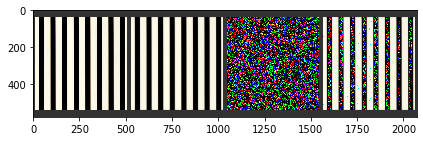

In [33]:
#@title Select Parameters { display-mode: "form", run: "auto" }
#@markdown ---
#@markdown Set Processing parameters
Image_Blur_Deviation = 2  #@param {type: "slider", min: 0, max: 4, step: 1} 
kernel_size =  7#@param {type:"slider", min:1, max:11, step:2} 
mean_noise = 0 #@param {type: "number"}
sigma_noise = 1.2 #@param {type:"slider", min:0, max:4, step:0.1} 
#@markdown Boarder Color
red = 50 #@param {type:"slider", min:0, max:255, step:1} 
green = 50 #@param {type:"slider", min:0, max:255, step:1} 
blue = 50 #@param {type:"slider", min:0, max:255, step:1} 
#@markdown Boarder Thickness
boarder_thickness = 38 #@param {type:"slider", min:0, max:100, step:1}
#@markdown ---

print("Set the following...\n Blur_deviation: {}\n Kernel Size: {}".format(Image_Blur_Deviation, (kernel_size, kernel_size) ))

img.blur_img((kernel_size, kernel_size), Image_Blur_Deviation)

# Setting noise levels
img.noise_img(mean_noise, sigma_noise) # noise image is set. 

# Setting Blurred image + Noise
img_model = img.blur.image + img.noise.image


value = [red, green, blue]  # RGB color value

'''
top: It is the border width in number of pixels in top direction. 
bottom: It is the border width in number of pixels in bottom direction. 
left: It is the border width in number of pixels in left direction. 
right: It is the border width in number of pixels in right direction. 
'''
boarder = lambda value, bt, imgs: [ cv2.copyMakeBorder(i, bt, bt, int(bt/4), int(bt/4), cv2.BORDER_CONSTANT, value=value) for i in imgs ]
x = [img.image, img.blur.image, img.noise.image, img_model]
x = boarder(value, boarder_thickness, x)
image_band = np.concatenate(x, axis=1)
Photo.show_array(image_band)



Add watermark and a form field to explore all combonations 

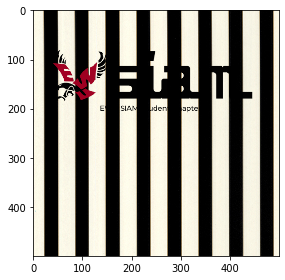

In [34]:
#@title Add a Watermark with Parameters { display-mode: "form", run: "auto" }
#@markdown alpha level to blend in watermark
alpha = 0.01 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown size level to transform watermark
size_param = 0.9 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown sy is percent location accros y-axis 

#@markdown sx is percent location accros x-axis
sy = 0.2 #@param {type:"slider", min:0, max:1, step:0.01}
sx = 0.32 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown ---

# Adding watermark...
h1,w1,c1 = watermark.shape
h, w, c = img.shape

location = [int(sy*(h-size_param*h1)), int(sx*(w- size_param*w1))]

composite_img = img.alpha_blend_watermark(watermark.image, size_param, location, alpha)

res_img = Image_Processing(img.fp, img.fname, composite_img)
res_img.show()


Set the following...
 Blur_deviation: 3
 Kernel Size: (7, 7)


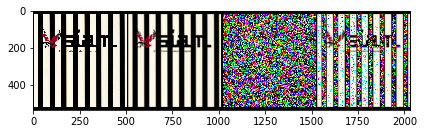

In [35]:
#@title Blurring and Noise the Composite Image { display-mode: "form", run: "auto" }
#@markdown ---
#@markdown Set Processing parameters
Image_Blur_Deviation = 3  #@param {type: "slider", min: 0, max: 4, step: 1}
kernel_size = 7 #@param {type:"slider", min:1, max:11, step:2}
mean_noise = 0 #@param {type: "number"}
sigma_noise = 3.5 #@param {type:"slider", min:0, max:4, step:0.1}
#@markdown Boarder Color
red = 0 #@param {type:"slider", min:0, max:255, step:1}
green = 0 #@param {type:"slider", min:0, max:255, step:1}
blue = 0 #@param {type:"slider", min:0, max:255, step:1}
#@markdown Boarder Thickness
boarder_thickness = 16 #@param {type:"slider", min:0, max:100, step:1}
#@markdown ---

print("Set the following...\n Blur_deviation: {}\n Kernel Size: {}".format(Image_Blur_Deviation, (kernel_size, kernel_size) ))

res_img.blur_img((kernel_size, kernel_size), Image_Blur_Deviation)

# Setting noise levels
res_img.noise_img(mean_noise, sigma_noise) # noise image is set. 

# Setting Blurred image + Noise
res_img_model = res_img.blur.image + res_img.noise.image


value = [red, green, blue]  # RGB color value

'''
top: It is the border width in number of pixels in top direction. 
bottom: It is the border width in number of pixels in bottom direction. 
left: It is the border width in number of pixels in left direction. 
right: It is the border width in number of pixels in right direction. 
'''
boarder = lambda value, bt, imgs: [ cv2.copyMakeBorder(i, bt, bt, int(bt/4), int(bt/4), cv2.BORDER_CONSTANT, value=value) for i in imgs ]


res_img_model =  Image_Processing("","", res_img_model )

x = [res_img.image, res_img.blur.image, res_img.noise.image, res_img_model.image]
x = boarder(value, boarder_thickness, x)
image_band = np.concatenate(x, axis=1)
Photo.show_array(image_band)


# Testing how to remove a watermark


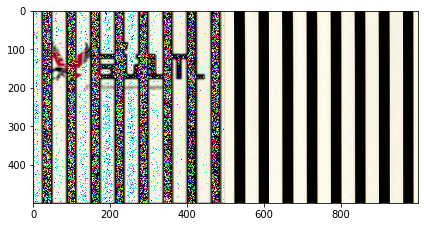

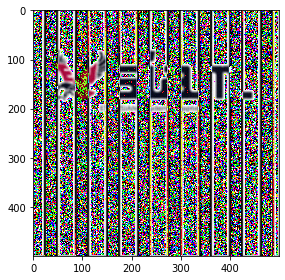

original  150031.77


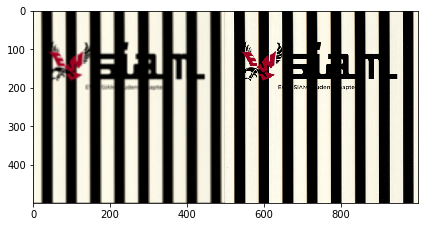

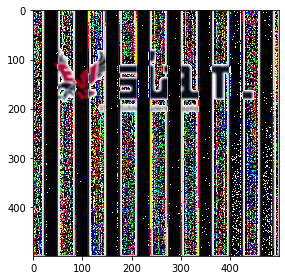

37474.805
blur  145140.72


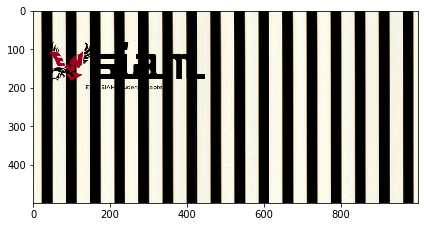

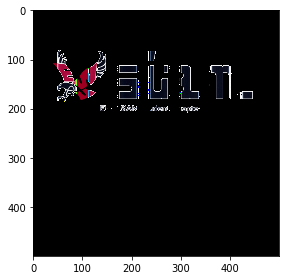

max 159.39
35969.82


"\n\ninit_w = np.asarray(res_img.image - img.image, dtype=np.float32)\n## Explore init_w data \n\n\n\n\ninit_beta = 0.0\nx0 = np.asarray(np.append(init_beta, init_w.reshape(m*n*c, )) )\nlb = np.zeros(np.shape(x0))\nub = 255*np.ones(np.shape(x0))\nub[0] = 1\nbounds = tuple(zip(lb,ub)) \n\ninit_beta_w = lsq(obj, x0=x0, args=(res_img.image, img.image )  )\n\n#init_beta_w = minimize(obj, x0=x0, args=(res_img.image, img.image ), method='L-BFGS-B', bounds=bounds, options={'maxiter':2}) \n\n\nprint(init_beta_w.x[:] )\n\nbeta = init_beta_w.x[0]\nw = init_beta_w.x[1:]\n\n\nPhoto.show_array(res_img.image -  beta*img.image)\ninit_w = res_img.image -  beta*img.image\n\n"

In [36]:
from skimage import color

res_img_model # is the img with watermark embedded and blurred and noised
img # is the original image with no blur or noise added 
# ####################################################################### #
# ####################### WATERMARKED  Blurred and Noised ############### #
Photo.show_array( np.hstack([res_img_model.image, img.image]) )
sol1 = res_img_model.image - img.image
Photo.show_array(sol1)

print("original ", np.linalg.norm(res_img.image))
# ####################################################################### #
# ####################### WATERMARKED  Blurred       #################### #
Photo.show_array( np.hstack([res_img.blur.image, res_img.image]) )
sol2 = res_img.blur.image - img.image
Photo.show_array(sol2)

print(np.linalg.norm(sol2))
print("blur ", np.linalg.norm(res_img.blur.image))
# ####################################################################### #
# ########################## WATERMARKED  ############################### #
Photo.show_array( np.hstack([res_img.image, img.image]) )
sol3 = res_img.image - img.image
Photo.show_array(sol3)

print("max", np.max(sol3))
print(np.linalg.norm(sol3))


from scipy.optimize import minimize
from scipy.optimize import least_squares as lsq

def obj(x,*args):
  with_watermark, original = args
  m,n,c = with_watermark.shape
  beta = x[0]
  approx_w = x[1:]
  return np.linalg.norm(with_watermark.reshape(m*n*c, ) -  (beta*original.reshape(m*n*c, ) + (1-beta)*approx_w ) )


m,n,c = res_img.shape
## grayscale your images
# watermarkBW = color.rgb2gray(res_img.image)
# imgBW = color.rgb2gray(img.image)

'''

init_w = np.asarray(res_img.image - img.image, dtype=np.float32)
## Explore init_w data 




init_beta = 0.0
x0 = np.asarray(np.append(init_beta, init_w.reshape(m*n*c, )) )
lb = np.zeros(np.shape(x0))
ub = 255*np.ones(np.shape(x0))
ub[0] = 1
bounds = tuple(zip(lb,ub)) 

init_beta_w = lsq(obj, x0=x0, args=(res_img.image, img.image )  )

#init_beta_w = minimize(obj, x0=x0, args=(res_img.image, img.image ), method='L-BFGS-B', bounds=bounds, options={'maxiter':2}) 


print(init_beta_w.x[:] )

beta = init_beta_w.x[0]
w = init_beta_w.x[1:]


Photo.show_array(res_img.image -  beta*img.image)
init_w = res_img.image -  beta*img.image

'''


# work on getting my BLUE for image restoration



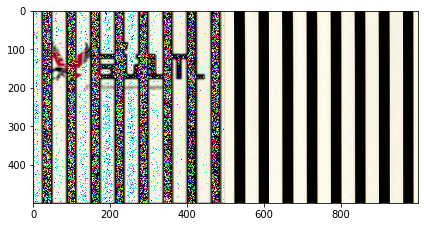

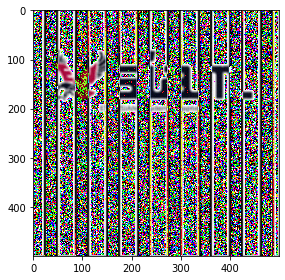

      fun: 18796.268
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.5])
0.5


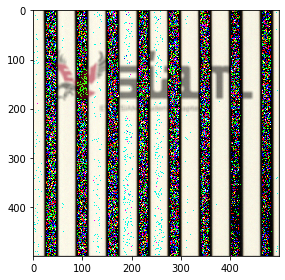

In [37]:
from skimage import color

res_img_model # is the img with watermark embedded and blurred and noised
img # is the original image with no blur or noise added 
# ####################################################################### #

# ####################################################################### #
# ########################## Blurred NOISED and WATERMARKED  ############################### #
Photo.show_array( np.hstack([res_img_model.image, img.image]) )
sol3 = res_img_model.image - img.image
Photo.show_array(sol3)



from scipy.optimize import minimize

def obj(x,*args):
  with_watermark, original = args
  beta = x[0]
  return np.linalg.norm(( beta)*with_watermark - (1-beta)*original) 


m,n,c = res_img.shape
## grayscale your images
# watermarkBW = color.rgb2gray(res_img.image)
# imgBW = color.rgb2gray(img.image)
# init_w = np.asarray(res_img.image - img.image, dtype=np.float32)
## Explore init_w data 

init_beta = 0.5
lb = 0
ub = 1

init_beta_w = minimize(obj, x0=np.asarray([init_beta]), args=(res_img_model.image, img.image), tol=0.0000009 ) 


print(init_beta_w)

beta = init_beta_w.x[0]
print(beta)

Photo.show_array(res_img_model.image - beta*(res_img_model.image - img.image))


# Try fft analysis instead 
 Checking the red channel only

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: ComplexWarning: Casting complex values to real discards the imaginary part


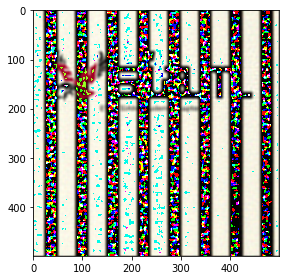

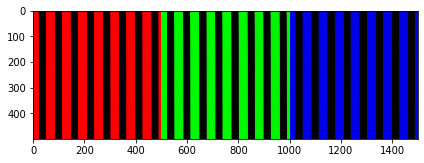

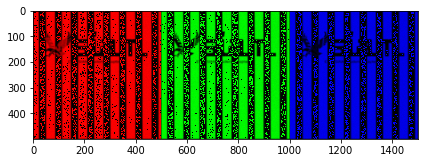

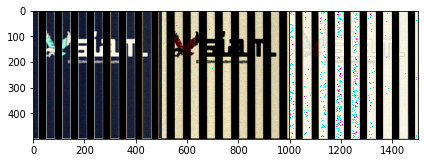

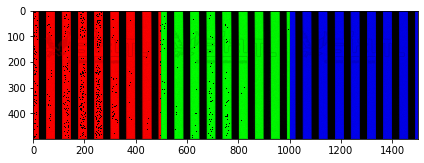

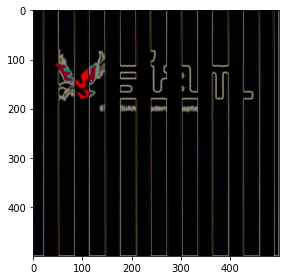

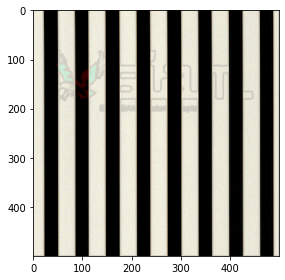

percent error in image restoration percent MSE(image - solution) :  0.006826779011495783
percent error in extraction: percent  MSE(target - solution)  0.05092541654724408


In [40]:
from scipy.fftpack import fft  
import scipy as sp

def threshold_filter(y, I, percentile=95):
  """
  Input: accepts a recieved RGB image with a watermark that may contain blur + noise, 
        the original clean RGB image with no watermark.
        Transforms RGB image with watermark and RGB image clean into frequency domain. 
  returns: A signal that is highly uncorellated to the original image. 
  """
  y_f = sp.fft.fftn(y/255)
  I_f = sp.fft.fftn(I/255)
  # Create a filter
  m, n = y_f.shape
  amplitude = np.abs(y_f).reshape(m*n)
  ir = np.abs(y_f*I_f).reshape(m*n)
  threshold = np.percentile(ir, q=percentile)
  for i in range(len(amplitude)):
    if ir[i] < threshold:
      y_f.reshape(m*n)[i] = 0
    else:
      pass
  return y_f.reshape(m,n) # returns the fft of the correlated signals with CI of ___ 


def get_h_RGB(x):
  sp = lambda image: [ image[:,:,ch] for ch in range(image.shape[2]) ]
  blue , green, red = sp(x)
  zeros = np.zeros(blue.shape, np.uint8)
  blueBGR = np.stack([blue,zeros,zeros], axis=2).astype(np.uint8)
  greenBGR = np.stack([zeros,green,zeros], axis=2).astype(np.uint8)
  redBGR = np.stack([zeros,zeros,red], axis=2).astype(np.uint8)
  return np.hstack((blueBGR, greenBGR, redBGR ))

## initialize each channel
target = res_img_model.image  # Image with Watermark and Blurred and Noised
# target = res_img.image + res_img.noise.image # Image with Watermark + noise
# target = res_img.image  # Image with Watermark
# target = img.image + img.noise.image  # Image no Watermark and Noised
# target = img.image # Image no Watermark
# target = img.blur.image # Image no Watermark

rgb = [ target[:,:,ch] for ch in range(res_img_model.image.shape[2]) ] # Image with Watermark and Blur + noised
RGB = [ img.image[:,:,ch] for ch in range(img.image.shape[2]) ] # Original Clean Image.

h_rgb = get_h_RGB(target)
h_RGB = get_h_RGB(img.image)


r,g,b = rgb
R,G,B = RGB 
n, m = r.shape

rgb_hat = np.zeros((n,m,3))
for i in range(img.image.shape[2]):
  y = rgb[i]
  I = RGB[i] 
  y_af = threshold_filter(y, I, percentile=95 )
  y_hat = sp.fft.ifftn(y_af)
  rgb_hat[:,:,i] = y_hat.reshape(n,m)
  

sol = (target*rgb_hat)
sol = sol/np.max(sol)
attempt = ( target )*(sol) + (1-sol)*img.image

Photo.show_array(255*rgb_hat)

Photo.show_array( h_RGB) 
Photo.show_array( h_rgb) 

Photo.show_array( np.hstack([(1-sol)*img.image, ( target )*(sol), attempt ]) )
Photo.show_array(get_h_RGB(attempt))


wtr_approx =  sol*np.abs((target - attempt) )
wtr_approx = 255*wtr_approx/np.max(wtr_approx)

solution = attempt
solution = 255*solution/np.max(solution)

Photo.show_array(wtr_approx)
Photo.show_array(solution)
print("percent error in image restoration percent MSE(image - solution) : ", 
      np.sum( np.square(img.image - solution))/ np.linalg.norm(img.image)**2 )
print("percent error in extraction: percent  MSE(target - solution) ", 
      np.sum( np.square(target - solution))/ np.linalg.norm(target)**2 )


# Testing some Concepts with the truncated svd


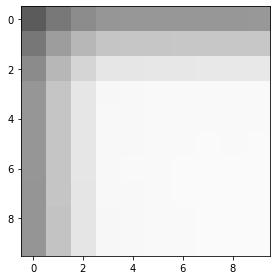

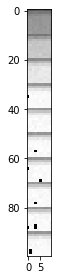

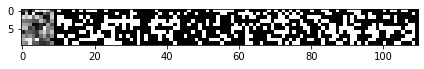

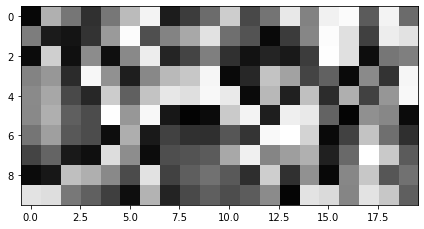

563649.7404678566
7950.710627370345 250.42343


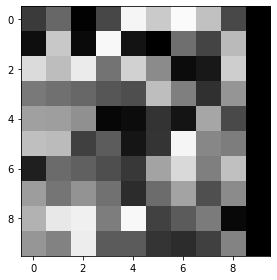

In [39]:
from skimage import color
from skimage import io
import sklearn.decomposition as skd
import pandas as pd


test = img.blur.image


BLUR = img.blur.image
NOISE = img.noise.image

test = test[0:10, 0:10]
img_tester  = Image_Processing(" "," ", test)
imgBWO = color.rgb2gray(test)

## Show imgbwO
Photo.show_array(imgBWO)
k_noise =[]
sol = []
for i in range(10):
  img_tester.noise_img(mean_noise, sigma_noise+np.random.random())
  imgBW = (color.rgb2gray(img_tester.image) + color.rgb2gray(img_tester.noise.image))/255
  n,m = imgBW.shape
  imgBW = imgBW.reshape((n*m,1))
  kn = color.rgb2gray(img_tester.noise.image)
  kn = kn.reshape((m*n,1))
  sol.append(255*imgBW)
  k_noise.append(kn)

## show sol as image vectorized and random noise added. 
Photo.show_array(np.concatenate(sol, axis=1))

trials = np.asarray(sol)
mean = trials.mean(axis=0)


x_hat = trials - mean*np.ones(trials.shape)
x_hat = x_hat[:,:,0]


trsvd = skd.TruncatedSVD(n_components=15)

transformed = 255*trsvd.fit_transform(x_hat)
temp = [k_noise[i].reshape(m,n) for i in range(len(k_noise))]
temp.append(transformed)
temp = list(reversed(temp))


## show svd decomp of image followed by all the random noised images. 
Photo.show_array(np.hstack( temp ) )

## Show original bwo and the difference of original - transformed. 
Photo.show_array(np.hstack([255*imgBWO, 255*imgBWO - transformed]))
print(np.linalg.norm(255*imgBWO - transformed))
print(np.max(transformed),np.max(np.asarray(imgBWO )) )

## show svd decomp of original
Photo.show_array(temp[0].reshape(m,n))

